Investment Analysis

Investment Analysis Points:

1) It wants to invest between 5 to 15 million USD per round of investment.

2) It wants to invest only in English-speaking countries because of the ease of communication with the companies.

Strategy:

a) Spark Funds wants to invest where most other investors are investing. This pattern is often observed among early stage startup investors.

Goals of data analysis: 

goals are divided into three sub-goals:

1) Investment type analysis: Comparing the typical investment amounts in the venture, seed, angel, private equity etc. so that Spark Funds can choose the type that is best suited for their strategy.

2) Country analysis: Identifying the countries which have been the most heavily invested in the past. These will be Spark Funds’ favourites as well.

3) Sector analysis: Understanding the distribution of investments across the eight main sectors. (Note that we are interested in the eight 'main sectors' provided in the mapping file. The two files — companies and rounds2 — have numerous sub-sector names; hence, you will need to map each sub-sector to its main sector.)


In [231]:
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import wikipedia as wp
import re
from matplotlib import pyplot as plt

# to return the country name from iso code
def get_country_names():
    iso3_iso2_data = requests.get('http://country.io/iso3.json').content
    iso2_to_country_data = requests.get('http://country.io/names.json').content
    iso3_to_iso_2_map = json.loads(iso3_iso2_data.decode('utf-8'))
    iso2_to_country_map = json.loads(iso2_to_country_data.decode('utf-8'))
    iso3_to_country_map = {v: iso2_to_country_map[k] for k, v in iso3_to_iso_2_map.items()}
    return iso3_to_country_map

# to get the english speaking countries
def get_english_speaking_countries():
    url = "https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language"
    table = pd.read_html(url, header=0)
    table = pd.concat([table[0], table[1]], axis = 0, sort=True)
    table = table.drop(['Nr','Population','Population1', 'Region'], axis=1)
    table = table[table['Primary language?'].str.contains('Yes')]
    table = table.drop(['Primary language?'], axis=1)
    table = table.rename(columns = {'Alpha-3 Code':'country_code'})
    table['Country'] = table['Country'].apply(lambda x: re.sub(r'([^a-zA-Z ]+?)','', x))
    return table

investement_fund_range = (5000000, 15000000)
# TODO:
# strip all data attrbiutes.
# remove special characters from each attribute.
# convert date format to proper date format.
# Remove Outlier which is above 95 % .
# Remove those rows for which company operation is closed. As we don't need to invest there.
# Impute data where NAN is less than 30 %

In [16]:
companies = pd.read_csv('companies.txt', sep='\t', encoding='unicode_escape')
companies.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/Organization/Laguna-Blends,Roost,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


In [17]:
# result expected
# 1. How many unique companies are present in rounds2? 90247
rounds2 = pd.read_csv('rounds2.csv', encoding='unicode_escape')
print(len(rounds2['company_permalink'].unique()))

90247


In [18]:
# 2. How many unique companies are present in companies? 66368
print(len(companies['permalink'].unique()))

66368


In [19]:
# 3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.
# permalink

In [208]:
# 4. Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N 
companies = companies.rename(columns={'permalink':'company_permalink'})
companies['company_permalink'] = companies['company_permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
rounds2_ex_companies = rounds2.merge(companies, how='left', on='company_permalink')
rounds2_ex_companies.loc[rounds2_ex_companies['name'].isnull() & rounds2_ex_companies['homepage_url'].isnull()].count()
# Total 7 companies which exist rounds2 file.
# Yes

# 5. Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame.
# Name the merged frame master_frame. How many observations are present in master_frame?
# Ignoring the companies which doesn't exist on the companies file.
master_frame = companies.merge(rounds2, how='inner', on='company_permalink')

master_frame = master_frame[master_frame.raised_amount_usd.notnull()]    
master_frame['raised_amount_usd'] = master_frame['raised_amount_usd'].apply(lambda x: int(x))
# 114942

Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity)

Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?

,min,max,sum,mean,median,count
funding_round_type,,,,,,
private_equity,0,4745460219,141925436105,73308593,20000000,1936
venture,0,17600000000,590126216876,11748949,5000000,50228
angel,0,494511992,4659255123,958694,400000,4860
seed,0,200000000,16988238596,719779,275000,23602


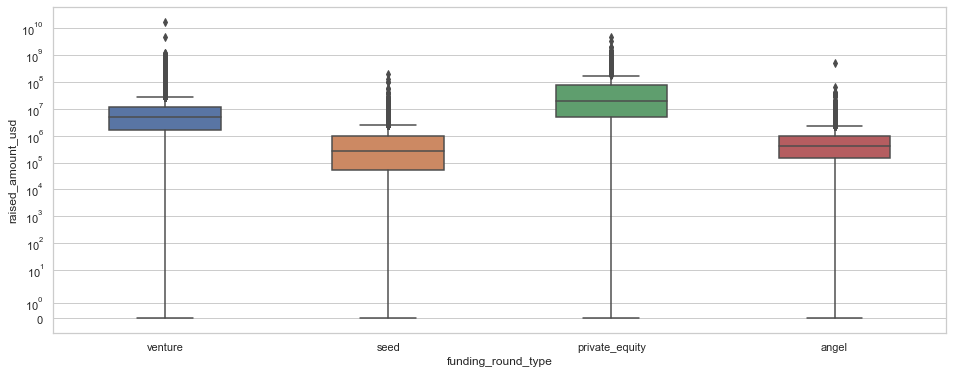

In [306]:
# drop the columns which is of no use for analysing the funding types
funding_analysis_frame = master_frame
funding_analysis_frame = funding_analysis_frame.drop(['homepage_url','state_code','funded_at', 'country_code'
                                                      ,'city', 'region','category_list', 'founded_at'
                                                      , 'funding_round_code']
                                                      , axis=1)
# As we are only interseted in these (venture, angel, seed, and private equity) four types of funding_type remove others funding types.
intersted_funding_types = ['venture', 'angel', 'seed', 'private_equity']
filtered_funding_analysis_frame = funding_analysis_frame[funding_analysis_frame['funding_round_type'].isin(intersted_funding_types)]     
#Visualize the box plot of this frame
plt.figure(100, figsize=(16, 6))
plt.yscale('symlog')
filtered_funding_analysis_frame
sns.boxplot(y='raised_amount_usd', 
                x='funding_round_type',
                data = filtered_funding_analysis_frame, width=0.5)

filtered_funding_analysis_frame = filtered_funding_analysis_frame.groupby('funding_round_type')['raised_amount_usd'].agg([min, max, sum, np.mean, np.median, 'count'])
filtered_funding_analysis_frame = filtered_funding_analysis_frame.sort_values(by='mean', ascending=False)
filtered_funding_analysis_frame['mean'] = filtered_funding_analysis_frame['mean'].apply(lambda x: int(x))
filtered_funding_analysis_frame
# prob: Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity)
# solution:
# Venture:  11748949
# angel: 958694
# seed: 719779
# private equity: 73308593

# prob: Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?
# since Spark Funds want to spend 5 to 15 million, 
# solution: Venture
# ------------------------------second breakpoint----------------------------------------------------

D:\anaconda\lib\site-packages\matplotlib\scale.py:489: RuntimeWarning: invalid value encountered in sign
  sign = np.sign(a)
D:\anaconda\lib\site-packages\numpy\ma\core.py:2146: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
D:\anaconda\lib\site-packages\numpy\ma\core.py:2146: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


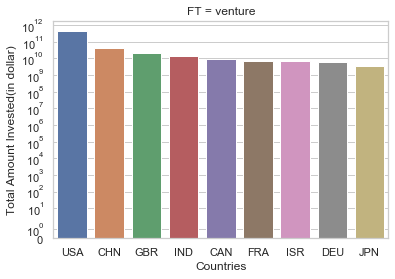

,country_code,min,max,sum,mean,count,Country
0,USA,0,17600000000,422510842796,1.169127e+07,36139,United States
1,GBR,0,915000000,20245627416,9.851887e+06,2055,United Kingdom
2,CAN,4697,165000000,9583332317,7.630042e+06,1256,Canada


In [307]:
# Country Analysis
given_funding_type = 'venture'  
top9 = master_frame[master_frame['funding_round_type']== given_funding_type].groupby(['country_code'])['raised_amount_usd'].agg([min, max, sum, np.mean, 'count']).sort_values(by='sum', ascending=False).head(9).reset_index()
top3_english_speaking_frame = top9.merge(get_english_speaking_countries(), how='inner', on='country_code').head(3)
plt.yscale('symlog')
ax = sns.barplot(y='sum', 
                x='country_code',
                data = top9)
ax.set(xlabel='Countries', ylabel="Total Amount Invested(in dollar)")
plt.title('FT = '+ given_funding_type)
plt.show()
# TODO: remove NAN from the values of master_frame
top_ctry = top3_english_speaking_frame['country_code'][0]
second_top_ctry = top3_english_speaking_frame['country_code'][1]
third_top_ctry = top3_english_speaking_frame['country_code'][2]
top3_english_speaking_frame

In [151]:
# Fetch mapping tables and remove unnecessary columns
mapping = pd.read_csv('mapping.csv', encoding='unicode_escape')
mapping['main_sector'] = mapping.iloc[:,1:].apply(lambda x: x.idxmax().strip(), axis=1)
mapping_ops = mapping[['category_list', 'main_sector']]


Top heavily invested company in D1 for top sector Others is Virtustream
Top heavily invested company in D2 for top sector Others is Electric Cloud
Top heavily invested company in D3 for top sector Cleantech / Semiconductors is EUSA Pharma
Top heavily invested company in D1 for second top sector Cleantech / Semiconductors is Biodesix
Top heavily invested company in D2 for second top sector Cleantech / Semiconductors is EUSA Pharma
Top heavily invested company in D3 for second top sector Others is Fresco Microchip


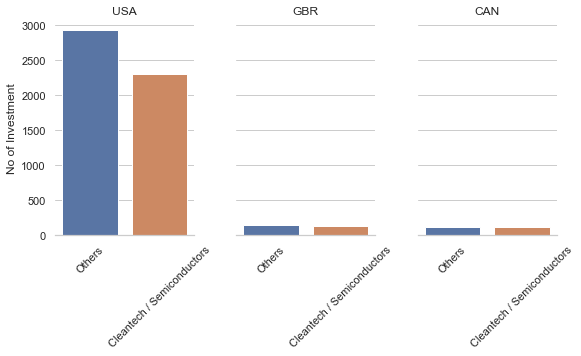

In [308]:
sector_analysis_frame = master_frame
sector_analysis_frame['primary_sector'] = sector_analysis_frame['category_list'].apply(lambda x: str(x).split('|')[0])
sector_analysis_frame = sector_analysis_frame.merge(mapping_ops, how = 'inner', left_on='primary_sector', right_on='category_list')
sector_analysis_frame = sector_analysis_frame.drop(['category_list_y'], axis = 1)
# filter for funding type FT and investment_range between (5000000, 15000000).
sector_analysis_frame = sector_analysis_frame.loc[(sector_analysis_frame['funding_round_type'] == given_funding_type) & (sector_analysis_frame['raised_amount_usd'].between(5000000, 15000000))]
D1 = sector_analysis_frame[(sector_analysis_frame['country_code'] == top_ctry)]
D2 = sector_analysis_frame[(sector_analysis_frame['country_code'] == second_top_ctry)]
D3 = sector_analysis_frame[(sector_analysis_frame['country_code'] == third_top_ctry)]
D1_investment = D1.groupby('main_sector')['raised_amount_usd'].agg([sum,'count']).sort_values(by='count', ascending=False)
top_sector_in_D1 = D1_investment.index[0]
second_top_sector_in_D1 = D1_investment.index[1]
total_no_of_investment_for_D1 = D1_investment.sum()
D2_investment = D2.groupby('main_sector')['raised_amount_usd'].agg([sum,'count']).sort_values(by='count', ascending=False)
total_no_of_investment_for_D2 = D2_investment.sum()
top_sector_in_D2 = D2_investment.index[0]
second_top_sector_in_D2 = D2_investment.index[1]
D3_investment = D3.groupby('main_sector')['raised_amount_usd'].agg([sum,'count']).sort_values(by='count', ascending=False)
total_no_of_investment_for_D3 = D3_investment.sum()
top_sector_in_D3 = D3_investment.index[0]
second_top_sector_in_D3 = D3_investment.index[1]

print('Top heavily invested company in D1 for top sector '+ top_sector_in_D1 + ' is '+ D1[D1['main_sector']==top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D2 for top sector '+ top_sector_in_D2 +' is ' + D2[D2['main_sector']==top_sector_in_D2].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D3 for top sector '+ top_sector_in_D3 + ' is ' + D2[D2['main_sector']==top_sector_in_D3].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])

print('Top heavily invested company in D1 for second top sector '+ second_top_sector_in_D1 + ' is '+ D1[D1['main_sector']==second_top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D2 for second top sector '+ second_top_sector_in_D2 + ' is '+ D2[D2['main_sector']==second_top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D3 for second top sector '+ second_top_sector_in_D3 + ' is '+ D3[D3['main_sector']==second_top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])

sector_analysis_frame = sector_analysis_frame.loc[(sector_analysis_frame['country_code'].isin([top_ctry, second_top_ctry, third_top_ctry ])) & (sector_analysis_frame['main_sector'].isin([top_sector_in_D1, top_sector_in_D2, top_sector_in_D3]))]
sector_analysis_frame = sector_analysis_frame.groupby(['country_code', 'main_sector'])['raised_amount_usd'].agg(['count']).sort_values(['country_code','count'], ascending=False).reset_index()
g = sns.catplot(x="main_sector", y="count", col="country_code",data=sector_analysis_frame, kind="bar",height=4, aspect=.7)
(g.set_axis_labels("", "No of Investment")
.set_titles("{col_name}")
.despine(left=True))
(g.set_xticklabels(rotation=45))